In [1]:
"""
Reference: https://www.drivendata.co/blog/predict-pm25-benchmark/

We are going to use some of the explanations regarding satellite data processing with 
geo-location information to help pre-process the data.

The biggest problem with the data is that there are a lot of missing values (or NaN values)

"""
# File manipulation
import os

# Pandas and Numpy
import numpy as np
import pandas as pd

# Date time manipulation
from datetime import datetime, timedelta
from dateutil import parser
import time

# Tensorflow/Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras.backend as backend
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor

# SKlearn
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# Matplotlib
import matplotlib.pyplot as plt

# Geo data processing
import geopandas as gpd
from pyhdf.SD import SD, SDC, SDS
import pyproj
from pyproj import CRS, Proj
from typing import Union
from shapely.geometry import Point, Polygon

# Pickle
import pickle as pkl

# BZ2
import bz2

# PQDM for parallel procesing
from pqdm.processes import pqdm


Using TensorFlow backend.


In [2]:
# Inspect one dataset
# We are going to take out some of the attributes we need to generate imputation values later
hdf = SD(os.path.join('train', '20180201T191000_maiac_la_0.hdf'))

for field, data in hdf.datasets().items():
    print(field, "->", data)
    
print("")

blue_band_AOD = hdf.select("Optical_Depth_047")
green_band_AOD = hdf.select("Optical_Depth_055")
aod_uncertainty = hdf.select("AOD_Uncertainty")
finemodefraction = hdf.select("FineModeFraction")
column_wv = hdf.select("Column_WV")
aod_qa = hdf.select("AOD_QA")
aod_model = hdf.select("AOD_MODEL")
injection_height = hdf.select("Injection_Height")
cosSZA = hdf.select("cosSZA")
cosVZA = hdf.select("cosVZA")
relAZ = hdf.select("RelAZ")
scattering_angle = hdf.select("Scattering_Angle")
glint_angle = hdf.select("Glint_Angle")

Optical_Depth_047 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 0)
Optical_Depth_055 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 1)
AOD_Uncertainty -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 2)
FineModeFraction -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 3)
Column_WV -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 4)
AOD_QA -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 23, 5)
AOD_MODEL -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 21, 6)
Injection_Height -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 5, 7)
cosSZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 8)
cosVZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 9)
RelAZ -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 2

In [3]:
raw_attr = hdf.attributes()["StructMetadata.0"] # Look at Metadata
print(raw_attr)
group_1 = raw_attr.split("END_GROUP=GRID_1")[0] # Pick out only 5km field in the metadata
# print(group_1)

hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except (NameError, ValueError, SyntaxError):
        hdf_metadata[key] = val

for key, value in hdf_metadata.items():
    print(key, '->', value)

print("")
    
# Note that coordinates are provided in meters
# We construct an alignment dictionary parameter
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}

for key, value in alignment_dict.items():
    print(key, '->', value)


GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="grid1km"
		XDim=1200
		YDim=1200
		UpperLeftPointMtrs=(-11119505.196667,4447802.078667)
		LowerRightMtrs=(-10007554.677000,3335851.559000)
		Projection=GCTP_SNSOID
		ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)
		SphereCode=-1
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Orbits"
				Size=4
			END_OBJECT=Dimension_1
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Optical_Depth_047"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Optical_Depth_055"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_2
			OBJECT=DataField_3
				DataFieldName="AOD_Uncertainty"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_3
			OBJECT=DataField_4
				DataFieldName="FineModeFraction"
				Data

In [4]:
##################
#DATA PROCESSING #
##################
# Loop over orbits to apply the attributes
def calibrate_data(dataset, shape, calibration_dict):
    """
    Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        if 'add_offset' not in calibration_dict:
            offset = 0
        else:
            offset = calibration_dict["add_offset"]
        if 'scale_factor' not in calibration_dict:
            scale_factor = 1
        else:
            scale_factor = calibration_dict["scale_factor"]
        data = (
            (data - offset) *
            scale_factor
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

calibration_dict = blue_band_AOD.attributes()
name, num_dim, shape, types, num_attr = blue_band_AOD.info()
# Test calibrate_data function
corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)

In [5]:
# Aligning AOD data with real world coordinates
def create_meshgrid(alignment_dict, shape):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

xv, yv = create_meshgrid(alignment_dict, shape)

In [6]:
# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat

# Project sinu grid onto wgs84 grid
lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

In [7]:
def convert_array_to_df(
    corrected_arr,
    lat,
    lon,
    granule_id,
    crs,
    total_bounds = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

def plot_gdf(gdf, separate_bands=True, title='Blue Band AOD'):
    """Plot the Point objects contained in a GeoDataFrame.
    Option to overlay bands.
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame with, at a minimum,
            columns for `orbit`, `geometry`, and `value`.
        separate_bands (bool): Plot each band on its own axis.
            Defaults to True.
    
    Displays a matplotlib scatterplot.
    """
    if separate_bands:
        num_orbits = gdf.orbit.max() + 1
        f, axes = plt.subplots(
            1,
            num_orbits,
            figsize=(20, 5),
            sharex=True,
            sharey=True
        )
        for i, ax in enumerate(axes):
            gdf_orbit = gdf[gdf.orbit == i]
            img = ax.scatter(
                x=gdf_orbit.geometry.x,
                y=gdf_orbit.geometry.y,
                c=gdf_orbit.value,
                s=0.1,
                alpha=1,
                cmap="RdYlBu_r"
            )
            ax.set_title(f"Band {i + 1}", fontsize=12)
    else:
        f, ax = plt.subplots(1, 1, figsize=(4, 4))
        img = ax.scatter(
            x=gdf.geometry.x,
            y=gdf.geometry.y,
            c=gdf.value,
            s=0.15,
            alpha=1,
            cmap="RdYlBu_r"
        )
    f.colorbar(img)
    plt.suptitle(title, fontsize=12)

(1203568, 4)
                       granule_id  orbit                     geometry  value
0  20180201T191000_maiac_la_0.hdf      0  POINT (-110.79078 35.36280)  0.110
1  20180201T191000_maiac_la_0.hdf      0  POINT (-110.78956 35.35446)  0.076
2  20180201T191000_maiac_la_0.hdf      0  POINT (-110.28947 35.28774)  0.112


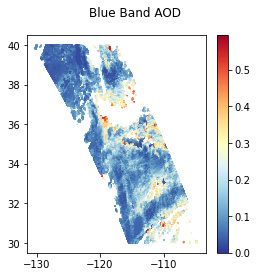

In [8]:
gdf = convert_array_to_df(corrected_AOD, lat, lon, '20180201T191000_maiac_la_0.hdf', wgs84_crs)
print(gdf.shape)
print(gdf.head(3))

plot_gdf(gdf, separate_bands=False)

In [9]:
# Some more helpful functions from the tutorial
def create_calibration_dict(data):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()

def create_alignment_dict(hdf):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

In [10]:
# Importing HDF data and creating a set of raw hdf files.
train_labels = pd.read_csv("train_labels.csv")
train_labels['Date'] = pd.to_datetime(train_labels['datetime'], format='%Y-%m-%d')
train_labels['Year'] = train_labels['Date'].dt.year
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')
test_labels = pd.read_csv("submission_format.csv")

la_gc = grid_metadata[grid_metadata['location'] == "Los Angeles (SoCAB)"].copy()
dl_gc = grid_metadata[grid_metadata['location'] == "Delhi"].copy()
tp_gc = grid_metadata[grid_metadata['location'] == "Taipei"].copy()

# Confirm all LA, Taipei, Delhi grid cells are in our training labels
assert la_gc['grid_id'].isin(train_labels.grid_id).all()
assert dl_gc['grid_id'].isin(train_labels.grid_id).all()
assert tp_gc['grid_id'].isin(train_labels.grid_id).all()

print("LA Grid Len:", len(la_gc))
print("Delhi Grid Len:", len(dl_gc))
print("Taipei Grid Len:", len(tp_gc))

print(train_labels.head(n=10))

# satellite_metadata = satellite_metadata[satellite_metadata.granule_id.str.endswith('f')]
# satellite_metadata = satellite_metadata[satellite_metadata['split'] == 'train']
# print(satellite_metadata)
# raw_hdf_set = set(satellite_metadata['granule_id'])

LA Grid Len: 14
Delhi Grid Len: 33
Taipei Grid Len: 7
               datetime grid_id  value                      Date  Year
0  2018-02-01T08:00:00Z   3S31A   11.4 2018-02-01 08:00:00+00:00  2018
1  2018-02-01T08:00:00Z   A2FBI   17.0 2018-02-01 08:00:00+00:00  2018
2  2018-02-01T08:00:00Z   DJN0F   11.1 2018-02-01 08:00:00+00:00  2018
3  2018-02-01T08:00:00Z   E5P9N   22.1 2018-02-01 08:00:00+00:00  2018
4  2018-02-01T08:00:00Z   FRITQ   29.8 2018-02-01 08:00:00+00:00  2018
5  2018-02-01T08:00:00Z   H96P6   12.8 2018-02-01 08:00:00+00:00  2018
6  2018-02-01T08:00:00Z   PG3MI   21.0 2018-02-01 08:00:00+00:00  2018
7  2018-02-01T08:00:00Z   QJHW4    5.2 2018-02-01 08:00:00+00:00  2018
8  2018-02-01T08:00:00Z   WT52R    6.5 2018-02-01 08:00:00+00:00  2018
9  2018-02-01T08:00:00Z   X5DKW   17.7 2018-02-01 08:00:00+00:00  2018


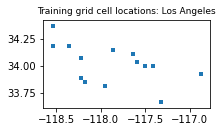

In [11]:
la_polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs) # used for WGS 84
la_polys.name = "geometry"
la_polys_gdf = gpd.GeoDataFrame(la_polys)

la_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Los Angeles", fontsize=9);

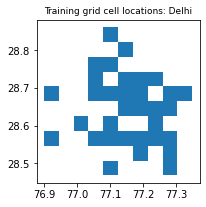

In [12]:
dl_polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs) # used for WGS 84
dl_polys.name = "geometry"
dl_polys_gdf = gpd.GeoDataFrame(dl_polys)

dl_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Delhi", fontsize=9);

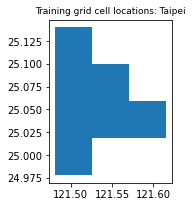

In [13]:
tp_polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs) # used for WGS 84
tp_polys.name = "geometry"
tp_polys_gdf = gpd.GeoDataFrame(tp_polys)

tp_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Taipei", fontsize=9);

In [14]:
# For pqdm if necessary
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
# We split train_labels into train and cross validation

train_actual_labels = train_labels[train_labels['Year'] <= 2019].copy()
train_cross_val_labels = train_labels[train_labels['Year'] > 2019].copy()

# print(len(train_actual_labels.index))
# print(len(train_cross_val_labels.index))

# We randomly pick a few training data points to test the feature generation algorithm
n = 2000
# train_labels_subset = train_actual_labels.sample(n=n).copy()
test_labels_subset = test_labels.head(n=n).copy()

def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

def fetch_satellite_meta(metadata, date_time, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"

    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parser.parse(date_time)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

def fetch_granule_id(grid_id, date_time, split):
    temp = get_grid_data(grid_metadata, grid_id)
    location = temp.iloc[0]['location']
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               date_time, 
                               location, 
                               "maiac", 
                               split)
    granule_ids = []
    for i in range(len(sat_met)):
        granule_id = sat_met.iloc[i]['granule_id']
        granule_ids.append(granule_id)
            
    return granule_ids, location

def fetch_alignment_dictionary(hdf, field_name):
    raw_attr = hdf.attributes()["StructMetadata.0"]  # Look at Metadata
    text_array = raw_attr.split("END_GROUP=GRID_1")  # The alignment values are always the same for a given HDF
       
    group_1 = text_array[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

    # Parse expressions still wrapped in apostrophes
    for key, val in hdf_metadata.items():
        try:
            hdf_metadata[key] = eval(val)
        except (NameError, ValueError, SyntaxError):
            hdf_metadata[key] = val

            
    # Note that coordinates are provided in meters
    # We construct an alignment dictionary parameter
    alignment_dict = {
        "upper_left": hdf_metadata["UpperLeftPointMtrs"],
        "lower_right": hdf_metadata["LowerRightMtrs"],
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    
    return alignment_dict

def preprocess_maiac_data(granule_id, location, split, field_name):
    # print(granule_id, location, split, field_name)
    hdf = SD(os.path.join(split, granule_id))
    field = hdf.select(field_name)
    name, num_dim, shape, types, num_attr = field.info()
    if field_name in ['AOD_QA']:
        corrected_field = field
    else:
        calibration_dict = field.attributes()
        corrected_field = calibrate_data(field, shape, calibration_dict)
    alignment_dict = fetch_alignment_dictionary(hdf, field_name)
    xv, yv = create_meshgrid(alignment_dict, shape)
    sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
    wgs84_crs = CRS.from_epsg("4326")
    lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
    
    if location == "Delhi":
        polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs)
    elif location == "Taipei":
        polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs)
    else:
        polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs)
    
    polys.name = "geometry"
    polys_gdf = gpd.GeoDataFrame(polys)
    
    # xmin, ymin, xmax, ymax = polys_gdf.total_bounds
    gdf = convert_array_to_df(corrected_field, lat, lon, granule_id, wgs84_crs, polys_gdf.total_bounds)
    
    df = gpd.sjoin(polys_gdf, gdf, how="inner")
    
    hdf.end()
    
    return df.drop(columns="index_right").reset_index()

# Parallelize processes
# def preprocess_field_parallel(args, n_jobs=2):
#     args_sub = args[:2]
#     print(args_sub)
#     results = pqdm(args_sub, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")
#     return pd.concat(results)

def generate_features(train_labels, split="train"):
    labels = []
    features = []
    args = []
    
    out_folder_path = split + "_processed_pickles"
    if not os.path.isdir(out_folder_path):
        os.mkdir(out_folder_path)
    
    print("Length train_labels:", len(train_labels.index))
    startTime = time.time()
    for idx, i in enumerate(train_labels.index): 
        if idx%1000 == 0:  # Print out Elapsed time every 1000 elements
            elapsedTime = time.time() - startTime
            print("Current file index {:d}, Elapsed time: {}".format(idx, str(timedelta(seconds=elapsedTime))))
            
        granule_ids, location = fetch_granule_id(train_labels.loc[i]['grid_id'], train_labels.loc[i]['datetime'], split)
    
        pickle_output_dict = {}
        blueband_dataframe_list = []
        greenband_dataframe_list = []
        aod_uncertainty_dataframe_list = []
#         finemodefraction_dataframe_list = []
        column_wv_dataframe_list = []
#         injection_height_dataframe_list = []
#         aod_qa_dataframe_list = []
        
        for granule_id in granule_ids:
            result_blueband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_047'])
            result_greenband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_055'])
            result_aod_uncertainty = preprocess_maiac_data(*[granule_id, location, split, 'AOD_Uncertainty'])
#             result_finemodefraction = preprocess_maiac_data(*[granule_id, location, split, 'FineModeFraction'])
            result_column_wv = preprocess_maiac_data(*[granule_id, location, split, 'Column_WV'])
#             result_injection_height = preprocess_maiac_data(*[granule_id, location, split, 'Injection_Height'])
#             result_aod_qa = preprocess_maiac_data(*[granule_id, location, split, 'AOD_QA'])
            
            blueband_dataframe_list.append(result_blueband)
            greenband_dataframe_list.append(result_greenband)
            aod_uncertainty_dataframe_list.append(result_aod_uncertainty)
#             finemodefraction_dataframe_list.append(result_finemodefraction)
            column_wv_dataframe_list.append(result_column_wv)
#             injection_height_dataframe_list.append(result_injection_height)
#             aod_qa_dataframe_list.append(result_aod_qa)
        
        combined_blueband_df = pd.concat(blueband_dataframe_list)
        combined_greenband_df = pd.concat(greenband_dataframe_list)
        combined_aod_uncertainty_df = pd.concat(aod_uncertainty_dataframe_list)
#         combined_finemodefraction_df = pd.concat(finemodefraction_dataframe_list)
        combined_column_wv_df = pd.concat(column_wv_dataframe_list)
#         combined_injection_height_df = pd.concat(injection_height_dataframe_list)
#         combined_aod_qa_df = pd.concat(aod_qa_dataframe_list)
    
        pickle_output_dict['geodataframe_Optical_Depth_047'] = combined_blueband_df
        pickle_output_dict['geodataframe_Optical_Depth_055'] = combined_greenband_df
        pickle_output_dict['geodataframe_AOD_Uncertainty'] = combined_aod_uncertainty_df
        pickle_output_dict['geodataframe_Column_WV'] = combined_column_wv_df
    
        feature = []
        idx_offset = 3
        # Order of statistics: min, max, mean
        if combined_blueband_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_blueband_df['value'].min(), combined_blueband_df['value'].max(), 
                            combined_blueband_df['value'].mean()]) 
        
        if combined_greenband_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_greenband_df['value'].min(), combined_greenband_df['value'].max(), 
                            combined_greenband_df['value'].mean()]) 
        
        if combined_aod_uncertainty_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_aod_uncertainty_df['value'].min(), combined_aod_uncertainty_df['value'].max(), 
                            combined_aod_uncertainty_df['value'].mean()])
            
#         if combined_finemodefraction_df.empty:
#             feature.extend([np.nan] * idx_offset)
#         else:
#             feature.extend([combined_finemodefraction_df['value'].min(), combined_finemodefraction_df['value'].max(), 
#                             combined_finemodefraction_df['value'].mean()])
            
        if combined_column_wv_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_column_wv_df['value'].min(), combined_column_wv_df['value'].max(), 
                            combined_column_wv_df['value'].mean()])
        
#         if combined_injection_height_df.empty:
#             feature.extend([np.nan] * idx_offset)
#         else:
#             feature.extend([combined_injection_height_df['value'].min(), combined_injection_height_df['value'].max(), 
#                             combined_injection_height_df['value'].mean()])
        
#         if combined_aod_qa_df.empty:
#             feature.extend([np.nan, np.nan, np.nan])
#         else:
#             feature.extend([combined_aod_qa_df['value'].min(), combined_aod_qa_df['value'].max(), 
#                             combined_aod_qa_df['value'].mean()])
        
        label = train_labels.loc[i]['value']
        pickle_output_dict['label'] = label
        pickle_output_dict['min_max_mean_feature'] = feature
        
        # File name is "train/test" + "_" + "datetime" + "_" + "grid_id"
        filename = split + "_{}_{}".format((train_labels.loc[i]['datetime']).replace(":", "="), train_labels.loc[i]['grid_id'])
        full_path = os.path.join(out_folder_path, filename + '.pbz2')
        with bz2.BZ2File(full_path, 'wb') as f:
            pkl.dump(pickle_output_dict, f)
#         features.append(feature)
#         labels.append(label)
        
    return features, labels, idx_offset

features, labels, idx_offset = generate_features(test_labels_subset, "test")


Length train_labels: 2000
Current file index 0, Elapsed time: 0:00:00


In [ ]:
file = "train_2018-02-05T08=00=00Z_WT52R.pbz2"
full_path = os.path.join("train_processed_pickles", file)
data = bz2.BZ2File(full_path, 'rb')
data = pkl.load(data)

print(data)

In [ ]:
"""
Imputation and Scaler
"""

features_array = np.asarray(features)
labels_array = np.asarray(labels)

print(features_array.shape)
print(labels_array.shape)

# print(features_array)

# This function is a custom uniform random imputation function
# This should be updated based on how we generate the features in order to fill all the np.nan values with random valid values
# So if the feature list changes, we have to update this function
def custom_uniform_random_impute_function(features_array, idx_offset=3):
    idx = 0
    
    imputed_features_array = np.copy(features_array)
    
    # N columns are Blueband AOD
    calibration_dict = blue_band_AOD.attributes()
    blue_band_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of blue band AOD nan:", blue_band_features[np.isnan(blue_band_features)].size)
    blue_band_features[np.isnan(blue_band_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                         high=calibration_dict['valid_range'][1], 
                                                                         size=blue_band_features[np.isnan(blue_band_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    blue_band_features = (blue_band_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = blue_band_features
    
    # N columns are Greenband AOD
    idx += idx_offset
    calibration_dict = green_band_AOD.attributes()
    green_band_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of green band AOD nan:", green_band_features[np.isnan(green_band_features)].size)
    green_band_features[np.isnan(green_band_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                           high=calibration_dict['valid_range'][1], 
                                                                           size=green_band_features[np.isnan(green_band_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    green_band_features = (green_band_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = green_band_features
    
    # N columns are AOD Uncertainty
    idx += idx_offset
    calibration_dict = aod_uncertainty.attributes()
    aod_uncertainty_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of AOD Uncertainty nan:", aod_uncertainty_features[np.isnan(aod_uncertainty_features)].size)
    aod_uncertainty_features[np.isnan(aod_uncertainty_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                                     high=calibration_dict['valid_range'][1], 
                                                                                     size=aod_uncertainty_features[np.isnan(aod_uncertainty_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    aod_uncertainty_features = (aod_uncertainty_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = aod_uncertainty_features
    
    # N columns are FineModeFraction
#     idx += idx_offset
#     calibration_dict = finemodefraction.attributes()
#     finemodefraction_features = imputed_features_array[:, idx:idx+idx_offset]
#     print("Number of FineModeFraction nan:", finemodefraction_features[np.isnan(finemodefraction_features)].size)
#     finemodefraction_features[np.isnan(finemodefraction_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
#                                                                                        high=calibration_dict['valid_range'][1], 
#                                                                                        size=finemodefraction_features[np.isnan(finemodefraction_features)].shape)
#     if 'add_offset' in calibration_dict:
#         offset = calibration_dict['add_offset']
#     else:
#         offset = 0
#     if 'scale_factor' in calibration_dict:
#         scale = calibration_dict['scale_factor']
#     else:
#         scale = 1
#     finemodefraction_features = (finemodefraction_features - offset) * scale
#     imputed_features_array[:, idx:idx+idx_offset] = finemodefraction_features
    
    # N columns are Column WV
    idx += idx_offset
    calibration_dict = column_wv.attributes()
    column_wv_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of Column WV nan:", column_wv_features[np.isnan(column_wv_features)].size)
    column_wv_features[np.isnan(column_wv_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                         high=calibration_dict['valid_range'][1], 
                                                                         size=column_wv_features[np.isnan(column_wv_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    column_wv_features = (column_wv_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = column_wv_features
    
    # N columns are Injection Height
#     idx += idx_offset
#     calibration_dict = injection_height.attributes()
#     injection_height_features = imputed_features_array[:, idx:idx+idx_offset]
#     print("Number of Injection Height nan:", injection_height_features[np.isnan(injection_height_features)].size)
#     injection_height_features[np.isnan(injection_height_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
#                                                                                        high=calibration_dict['valid_range'][1], 
#                                                                                        size=injection_height_features[np.isnan(injection_height_features)].shape)
#     if 'add_offset' in calibration_dict:
#         offset = calibration_dict['add_offset']
#     else:
#         offset = 0
#     if 'scale_factor' in calibration_dict:
#         scale = calibration_dict['scale_factor']
#     else:
#         scale = 1
#     injection_height_features = (injection_height_features - offset) * scale
#     imputed_features_array[:, idx:idx+idx_offset] = injection_height_features
    
    return imputed_features_array
    
imputed_features_array = custom_uniform_random_impute_function(features_array, idx_offset=idx_offset)

# print(imputed_features_array)
print(imputed_features_array.shape)

# This function is a custom Min Max Scaler function
# This should be updated based on how we generate the features
# So if the feature list changes, we have to update this function
def custom_MinMaxScaler_function(features_array, idx_offset=3):
    # y = (x – min) / (max – min)
    idx = 0
    
    transformed_features_array = np.copy(features_array)
    
    min_max_pair_list = []
    
    # N columns are Blueband AOD
    blue_band_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(blue_band_features)
    max_val = np.amax(blue_band_features)
    blue_band_features = (blue_band_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = blue_band_features
    
    # N columns are Greenband AOD
    idx += idx_offset
    green_band_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(green_band_features)
    max_val = np.amax(green_band_features)
    green_band_features = (green_band_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = green_band_features
    
    # N columns are AOD Uncertainty
    idx += idx_offset
    aod_uncertainty_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(aod_uncertainty_features)
    max_val = np.amax(aod_uncertainty_features)
    aod_uncertainty_features = (aod_uncertainty_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = aod_uncertainty_features
    
    # N columns are FineModeFraction
#     idx += idx_offset
#     finemodefraction_features = transformed_features_array[:, idx:idx+idx_offset]
#     min_val = np.amin(finemodefraction_features)
#     max_val = np.amax(finemodefraction_features)
#     finemodefraction_features = (finemodefraction_features - min_val)/(max_val - min_val)
#     min_max_pair_list.append((min_val, max_val))
#     transformed_features_array[:, idx:idx+idx_offset] = finemodefraction_features
    
    # N columns are Column WV
    idx += idx_offset
    column_wv_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(column_wv_features)
    max_val = np.amax(column_wv_features)
    column_wv_features = (column_wv_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = column_wv_features
    
    # N columns are Injection Height
#     idx += idx_offset
#     injection_height_features = transformed_features_array[:, idx:idx+idx_offset]
#     min_val = np.amin(injection_height_features)
#     max_val = np.amax(injection_height_features)
#     injection_height_features = (injection_height_features - min_val)/(max_val - min_val)
#     min_max_pair_list.append((min_val, max_val))
#     transformed_features_array[:, idx:idx+idx_offset] = injection_height_features
    
    return transformed_features_array, min_max_pair_list

transformed_features_array, min_max_pair_list = custom_MinMaxScaler_function(imputed_features_array, idx_offset=idx_offset)

# print(transformed_features_array)
print(transformed_features_array.shape)
print(min_max_pair_list)

In [ ]:
def flat_dense_model():  
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(12,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = flat_dense_model()
model.summary()

In [ ]:
print(type(transformed_features_array))
print(type(labels_array))

# For testing
history = model.fit(transformed_features_array, labels_array, epochs=2500, batch_size=20)

In [ ]:
def flat_dense_model_dropout_input():  
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(12,)))
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(30, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(10, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(5, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_dropout_input = flat_dense_model_dropout_input()
model_dropout_input.summary()

In [ ]:
# For testing
history = model_dropout_input.fit(transformed_features_array, labels_array, epochs=2500, batch_size=20)

In [ ]:
# Need to take out the Min-Max Scaling factor from training
# Apply the same impute on the cross validation features
# Run get feature on the cross validation set
# Then do predict and R^2

# train_cross_val_labels

# predicted = model.predict(np.array(features_cut))
# print(mean_squared_error(predicted, Y))
# r2_score(predicted, Y)
